<a href="https://colab.research.google.com/github/alikaiser12/AI/blob/main/Video_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def visualize_video_sequence(images, fps=30):
    """
    Visualizes a sequence of images as a video in a matplotlib plot.

    Parameters:
    - images (list of np.ndarray): List of frames to visualize.
    - fps (int): Frames per second, controlling the speed of the video display.

    Returns:
    - None
    """
    for img in images:
        # Check if the image was loaded successfully
        if img is not None:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
            plt.axis('off')
            plt.draw()
            plt.pause(1 / fps)
            plt.clf()
        else:
            print(f"Could not load image ")


# Example usage:
# Assume we have a list of frames in 'image_sequence'

# **CHANGE:** Ensure that this path is correct and the images actually exist
image_paths = [f"temp/frame_{i}.png" for i in range(1, 11)] # Assuming you saved the frames in 'temp' folder
image_sequence = [cv2.imread(path) for path in image_paths]

# image_sequence = [cv2.imread(f'frame_{i}.jpg') for i in range(10)]  # Replace with actual frames

visualize_video_sequence(image_sequence, fps=30)

Could not load image 
Could not load image 
Could not load image 
Could not load image 
Could not load image 
Could not load image 
Could not load image 
Could not load image 
Could not load image 
Could not load image 


In [ ]:
import os

# Define the folder path in Google Drive (adjust according to your folder structure)
data_path = '/content/drive/MyDrive/Video'

# List .jpg files in the folder
image_paths = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.lower().endswith('.png')]

# Print the list of image paths
print(image_paths)


['/content/drive/MyDrive/Video/img1.png', '/content/drive/MyDrive/Video/img2.png']


In [ ]:
import glob
import re
import os

# Define the folder path in Google Drive
data_path = '/content/drive/MyDrive/Video'

# Use glob to get all jpg files in the folder
# If a filename doesn't have digits, it will be treated as 0 for sorting.
image_paths = sorted(glob.glob(f"{data_path}/*.png"), key=lambda x: float(re.findall("(\d+)", x)[0]) if re.findall("(\d+)", x) else 0)

# Print the list of image paths
print(image_paths)

['/content/drive/MyDrive/Video/img1.png', '/content/drive/MyDrive/Video/img2.png']


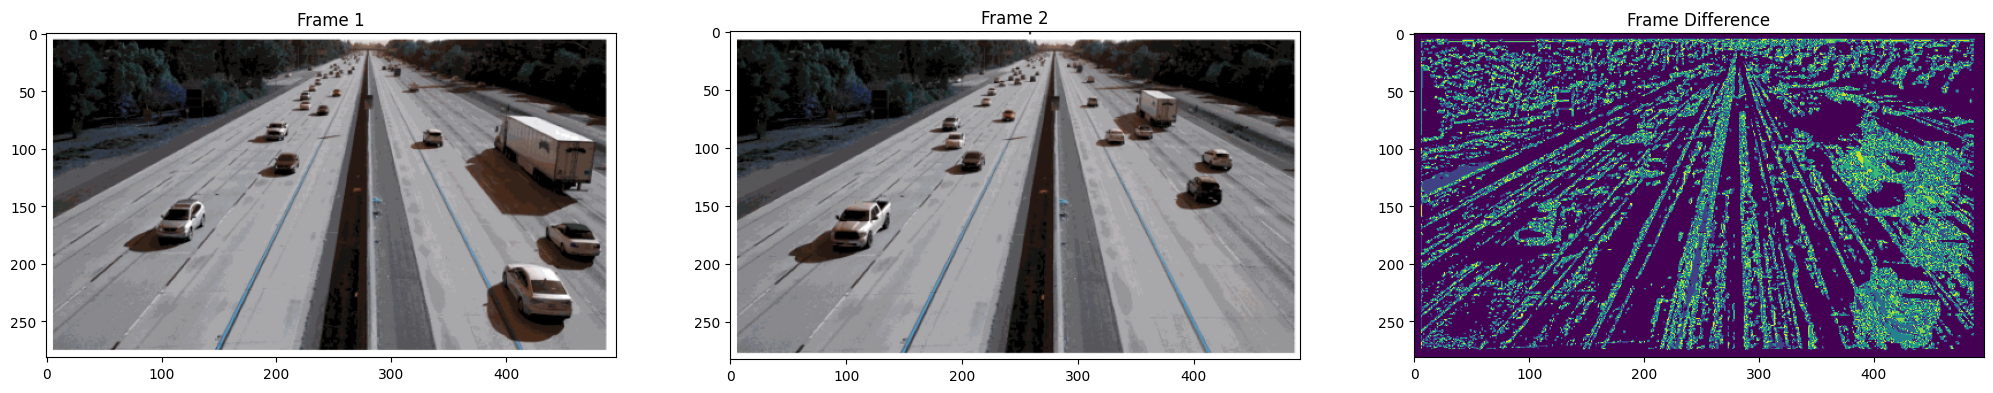

In [ ]:
idx = 0  # Or any other index within the range of your image_paths list (0 to 1 in this case)



# Use image_paths[idx] to access the correct image path
img1_rgb = cv2.cvtColor(cv2.imread(image_paths[idx]), cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(cv2.imread(image_paths[idx+1]), cv2.COLOR_BGR2RGB)

# ... (rest of your code)

# ... (rest of your code)

# convert to grayscale
img1 = cv2.cvtColor(img1_rgb, cv2.COLOR_RGB2GRAY)
img2 = cv2.cvtColor(img2_rgb, cv2.COLOR_RGB2GRAY)
# Resize img2 to match the dimensions of img1
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
# compute grayscale image difference
grayscale_diff = cv2.subtract(img2, img1)

fig, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(img1_rgb)
ax[0].set_title('Frame 1')
ax[1].imshow(img2_rgb)
ax[1].set_title('Frame 2')
ax[2].imshow(grayscale_diff*50) # scale the frame difference to show the noise
ax[2].set_title('Frame Difference');

In [ ]:
def get_mask(frame1, frame2, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs:
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            kernel - (NxN) array for Morphological Operations
        Outputs:
            mask - Thresholded mask for moving pixels
        """
    frame_diff = cv2.subtract(frame2, frame1)

    # blur the frame difference
    frame_diff = cv2.medianBlur(frame_diff, 3)

    mask = cv2.adaptiveThreshold(frame_diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY_INV, 11, 3)

    mask = cv2.medianBlur(mask, 3)

    # morphological operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return mask

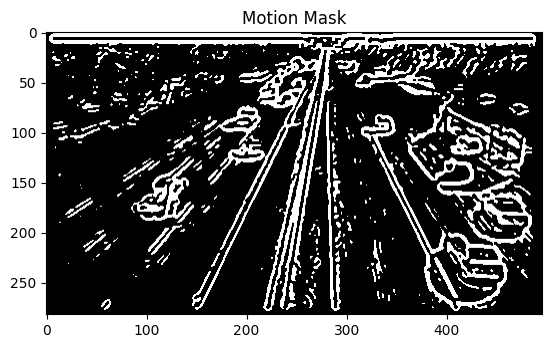

In [ ]:
kernel = np.array((9,9), dtype=np.uint8)
mask = get_mask(img1, img2, kernel)

plt.imshow(mask, cmap='gray')
plt.title("Motion Mask");

In [ ]:
def get_contour_detections(mask, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the mask.
        Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask,
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE,
                                   cv2.CHAIN_APPROX_TC89_L1)
    detections = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area > thresh: # hyperparameter
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

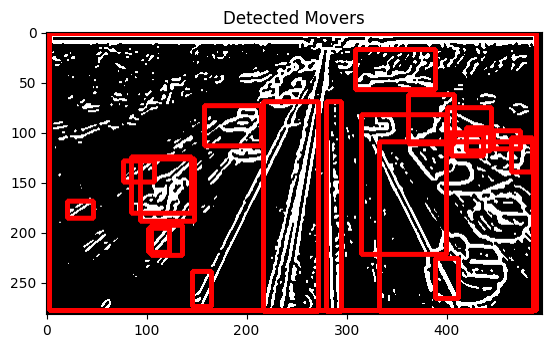

In [ ]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
detections = get_contour_detections(mask, thresh=400)

# separate bboxes and scores
bboxes = detections[:, :4]
scores = detections[:, -1]

for box in bboxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb)
plt.title("Detected Movers");

In [ ]:
def compute_iou(box1, box2):
    """ Obtains Intersection over union (IOU) of 2 bounding boxes
        Inputs are in the form of:
            xmin, ymin, xmax, ymax = box
        """
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2

    # get box points of intersection
    xi1 = max(x11, x12) # top left
    yi1 = max(y11, y12)
    xi2 = min(x21, x22) # bottom right
    yi2 = min(y21, y22)

    # compute intersectional area
    inter_area = max((xi2 - xi1 + 1), 0) * max((yi2 - yi1 + 1), 0)
    if inter_area == 0:
        return inter_area

    # compute box areas
    box1_area = (x21 - x11 + 1) * (y21 - y11 + 1)
    box2_area = (x22 - x12 + 1) * (y22 - y12 + 1)

    # return iou
    return inter_area / (box1_area + box2_area - inter_area)


def get_inter_area(box1, box2):
    """
    Obtains bounding box for intersection area of two boundning boxes
    Inputs are in the form of:
            xmin, ymin, xmax, ymax = box
    """
    x11, y11, x21, y21 = box1
    x12, y12, x22, y22 = box2

    # get box points of intersection
    xi1 = max(x11, x12) # top left
    yi1 = max(y11, y12)
    xi2 = min(x21, x22) # bottom right
    yi2 = min(y21, y22)

    # compute intersectional area
    inter_area = max((xi2 - xi1 + 1), 0) * max((yi2 - yi1 + 1), 0)
    if inter_area == 0:
        return 0, 0, 0, 0

    return xi1, yi1, xi2, yi2


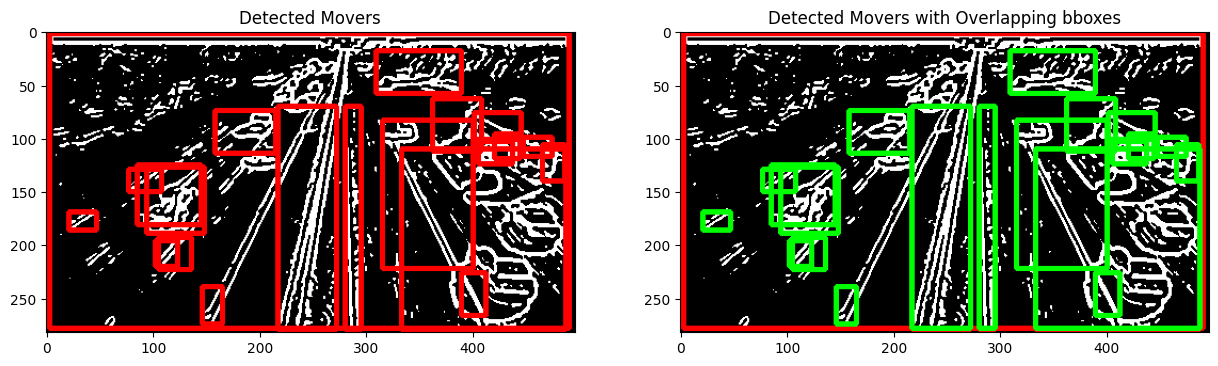

In [ ]:
mask_rgb_iou = mask_rgb.copy()

# only compare unique cases
idx_1, idx_2 = np.triu_indices(len(bboxes), k=1)

for i in range(len(idx_1)):
    b1 = bboxes[idx_1[i]].tolist()
    b2 = bboxes[idx_2[i]].tolist()
    iou = compute_iou(b1, b2)
    if iou > 0:
        # print(idx, np.round(iou,2))

        # draw intersection
        x1, y1, x2, y2 = get_inter_area(b1, b2)
        cv2.rectangle(mask_rgb_iou, (x1,y1), (x2,y2), (0,255,0), 3)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mask_rgb)
ax[0].set_title('Detected Movers')
ax[1].imshow(mask_rgb_iou)
ax[1].set_title('Detected Movers with Overlapping bboxes');

In [ ]:
def remove_contained_bboxes(boxes):
    """ Removes all smaller boxes that are contained within larger boxes.
        Requires bboxes to be soirted by area (score)
        Inputs:
            boxes - array bounding boxes sorted (descending) by area
                    [[x1,y1,x2,y2]]
        Outputs:
            keep - indexes of bounding boxes that are not entirely contained
                   in another box
        """
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep: # range(0, len(bboxes)):
        for j in range(0, len(boxes)):
            # check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep


def non_max_suppression(boxes, scores, threshold=1e-1):
    """
    Perform non-max suppression on a set of bounding boxes and corresponding scores.
    Inputs:
        boxes: a list of bounding boxes in the format [xmin, ymin, xmax, ymax]
        scores: a list of corresponding scores
        threshold: the IoU (intersection-over-union) threshold for merging bounding boxes
    Outputs:
        boxes - non-max suppressed boxes
    """
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    # remove all contained bounding boxes and get ordered index
    order = remove_contained_bboxes(boxes)

    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
            # Calculate the IoU between the two boxes
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            # Remove boxes with IoU greater than the threshold
            if iou > threshold:
                order.remove(j)

    return boxes[keep]

In [ ]:
%timeit nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)

705 µs ± 126 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
def non_max_suppression_2(boxes, scores, threshold=1e-1):
    """
    Perform non-max suppression on a set of bounding boxes and corresponding scores.
    NOTE: Eventhough we only go through 2 loops here, this way is more complicated and slower!
    Inputs:
        boxes: a list of bounding boxes in the format [xmin, ymin, xmax, ymax]
        scores: a list of corresponding scores
        threshold: the IoU (intersection-over-union) threshold for merging bounding boxes
    Outputs:
        boxes - non-max suppressed boxes
    """
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    keep = list(range(0, len(boxes)))
    for i in keep:
        for j in range(0, len(bboxes)):
            # check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == np.array([True, True, False, False])):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
            # if no overlap check IOU threshold
            else:
                # Calculate the IoU between the two boxes
                intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                            max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
                union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                        (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
                iou = intersection / union

                # Remove boxes with IoU greater than the threshold
                # ensure that we don't remove larger boxes by checking (j > i)
                if (iou > threshold) and (j > i):
                    try:
                        keep.remove(j)
                    except ValueError:
                        continue
    return boxes[keep]

In [ ]:

%timeit nms_bboxes = non_max_suppression_2(bboxes, scores, threshold=0.1)

1.13 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
nms_bboxes = non_max_suppression_2(bboxes, scores, threshold=0.1)
len(bboxes), len(nms_bboxes)

(21, 3)

In [ ]:
nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)
len(bboxes), len(nms_bboxes)

(21, 3)

In [ ]:
mask_rgb_detections = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
for det in nms_bboxes:
    x1, y1, x2, y2 = det
    cv2.rectangle(mask_rgb_detections, (x1,y1), (x2,y2), (255,0,0), 3)

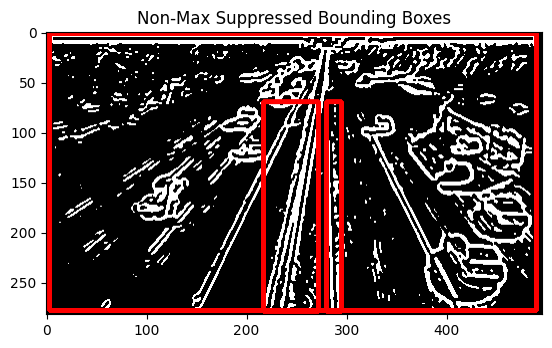

In [ ]:
plt.imshow(mask_rgb_detections)
plt.title("Non-Max Suppressed Bounding Boxes");

In [ ]:
def get_detections(frame1, frame2, bbox_thresh=400, nms_thresh=1e-3, mask_kernel=np.array((9,9), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            bbox_thresh - Minimum threshold area for declaring a bounding box
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            mask_kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # get image mask for moving pixels
    mask = get_mask(frame1, frame2, mask_kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(mask, bbox_thresh)

    # separate bboxes and scores
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    # perform Non-Maximal Supression on initial detections
    return non_max_suppression(bboxes, scores, nms_thresh)

In [ ]:
from PIL import Image


def draw_bboxes(frame, detections):
    for det in detections:
        x1,y1,x2,y2 = det
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)


def create_gif_from_images(save_path : str, image_path : str, ext : str) -> None:
    ''' creates a GIF from a folder of images
        Inputs:
            save_path - path to save GIF
            image_path - path where images are located
            ext - extension of the images
        Outputs:
            None
    '''
    ext = ext.replace('.', '')
    image_paths = sorted(glob(os.path.join(image_path, f'*.{ext}')))
    image_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    pil_images = [Image.open(im_path) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                       save_all=True, duration=50, loop=0)

In [ ]:
video_frames = []

for idx in range(1, len(image_paths)):
    # read frames
    frame1_bgr = cv2.imread(image_paths[idx - 1])
    frame2_bgr = cv2.imread(image_paths[idx])

    # Resize frame2 to match the dimensions of frame1
    frame2_bgr = cv2.resize(frame2_bgr, (frame1_bgr.shape[1], frame1_bgr.shape[0]))

    # get detections
    detections = get_detections(cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2GRAY),
                                cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2GRAY),
                                bbox_thresh=400,
                                nms_thresh=1e-4)


    # draw bounding boxes on frame
    draw_bboxes(frame2_bgr, detections)



    import os

# ... your code ...

# Before saving the figure
os.makedirs('temp', exist_ok=True)

# ... (rest of the code)
fig.savefig(f"temp/frame_{idx}.png")

# ... your code ...

    # save image for GIF
fig = plt.figure(figsize=(15, 7))
plt.imshow(frame2_bgr)
plt.axis('off')
plt.close();

# OPTIONAL append to list for video
video_frames.append(frame2_bgr)

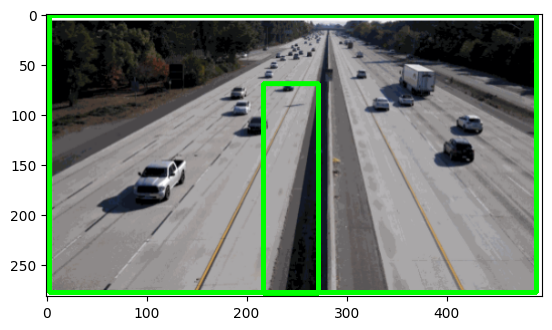

In [ ]:
plt.imshow(video_frames[0])

In [ ]:
from PIL import Image
# ... (Other imports) ...
from glob import glob # Import the glob function


def create_gif_from_images(save_path : str, image_path : str, ext : str) -> None:
    ''' creates a GIF from a folder of images
        Inputs:
            save_path - path to save GIF
            image_path - path where images are located
            ext - extension of the images
        Outputs:
            None
    '''
    ext = ext.replace('.', '')
    image_paths = sorted(glob(os.path.join(image_path, f'*.{ext}'))) # Use glob function
    image_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    pil_images = [Image.open(im_path) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                       save_all=True, duration=50, loop=0)

In [ ]:
out = cv2.VideoWriter('frame_differencing.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 25, (1920, 1080))

for img in video_frames:
    out.write(img)

out.release()
del out

In [ ]:
!pip install git+https://github.com/Eric-Canas/motion_detection_utils.git
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Now you should be able to import
try:
  from motion_detection_utils import *
except ModuleNotFoundError:
  print("Error: motion_detection_utils not found. Please check installation.")
  # Add additional troubleshooting or error handling here as needed.
  # For example, you could try to print the current Python path:
  import sys
  print(f"Python Path: {sys.path}")


  Cloning https://github.com/Eric-Canas/motion_detection_utils.git to /tmp/pip-req-build-8gjdbpmd
  Running command git clone --filter=blob:none --quiet https://github.com/Eric-Canas/motion_detection_utils.git /tmp/pip-req-build-8gjdbpmd
  fatal: could not read Username for 'https://github.com': No such device or address
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/Eric-Canas/motion_detection_utils.git /tmp/pip-req-build-8gjdbpmd did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/Eric-Canas/motion_detection_utils.git /tmp/pip-req-build-8gjdbpmd did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Error: motion_detection_utils n

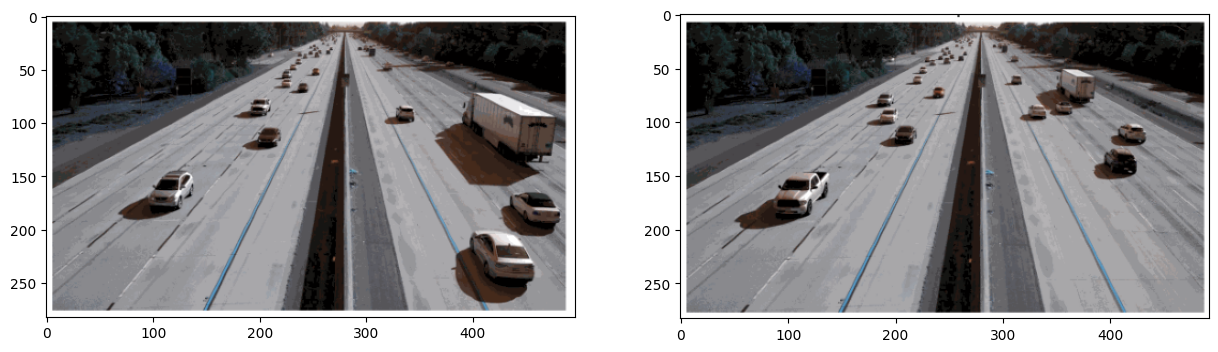

In [ ]:
idx = 0

frame1_bgr = cv2.imread(image_paths[idx])
frame2_bgr = cv2.imread(image_paths[idx+1])

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2RGB));

In [ ]:
def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # blurr image
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.75,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)
    return flow


def get_flow_viz(flow):
    """ Obtains BGR image to Visualize the Optical Flow
        """
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 1] = 255

    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

In [ ]:
def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # blurr image
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    # Resize gray2 to match the dimensions of gray1
    gray2 = cv2.resize(gray2, (gray1.shape[1], gray1.shape[0]))

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.75,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)
    return flow



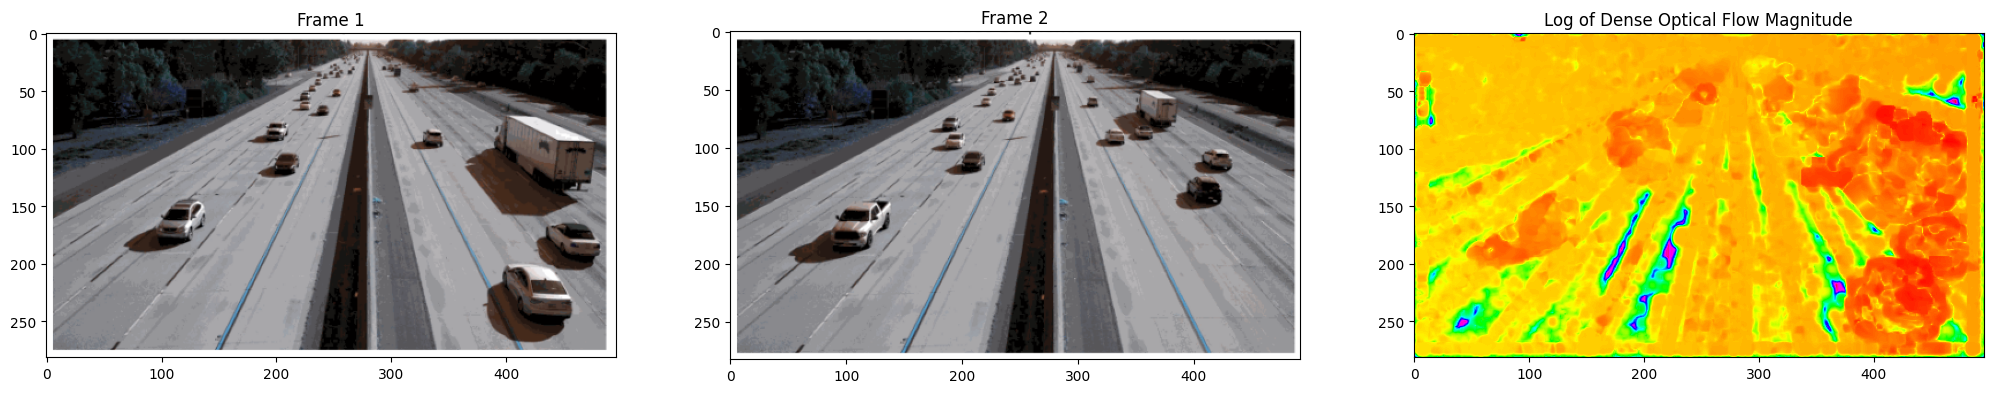

In [ ]:
# compute dense optical flow
flow = compute_flow(frame1_bgr, frame2_bgr)

# separate into magntiude and angle
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])


img1_rgb = cv2.cvtColor(frame1_bgr, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(frame2_bgr, cv2.COLOR_BGR2RGB)

# display
fig, ax = plt.subplots(1, 3, figsize=(25, 25))
ax[0].imshow(img1_rgb)
ax[0].set_title('Frame 1')
ax[1].imshow(img2_rgb)
ax[1].set_title('Frame 2')
ax[2].imshow(np.log(mag/mag.max()), cmap='hsv_r') # try other cmaps 'hsv_r', 'gist_earth_r', 'rainbow_r', 'twilight_r'
ax[2].set_title('Log of Dense Optical Flow Magnitude');

In [40]:
def get_motion_mask(flow_mag, motion_thresh=1, kernel=np.ones((7,7))):
    """ Obtains Detection Mask from Optical Flow Magnitude
        Inputs:
            flow_mag (array) Optical Flow magnitude
            motion_thresh - thresold to determine motion
            kernel - kernal for Morphological Operations
        Outputs:
            motion_mask - Binray Motion Mask
        """
    motion_mask = np.uint8(flow_mag > motion_thresh)*255

    motion_mask = cv2.erode(motion_mask, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=3)

    return motion_mask

In [41]:
mag.min(), mag.max()

(8.676014e-13, 145.22993)

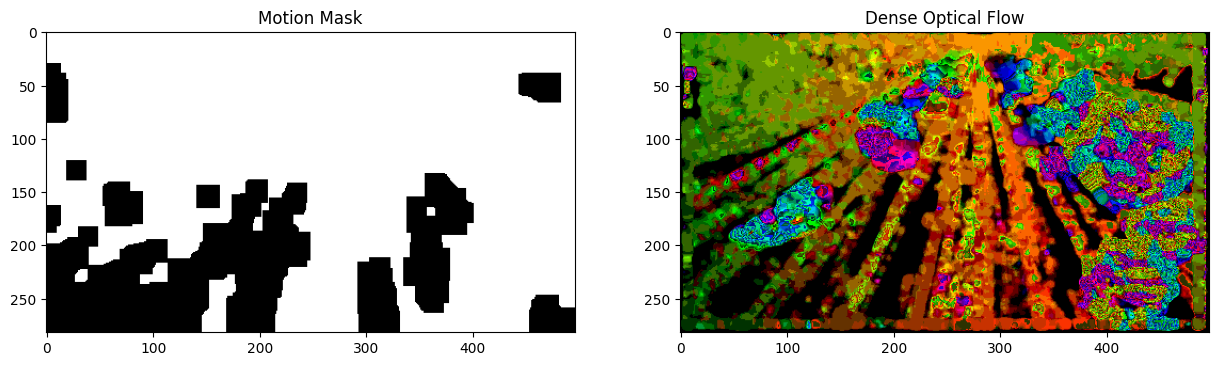

In [43]:
# get optical flow visualization
# get optical flow visualization
rgb = get_flow_viz(flow)

# Get the shape of the optical flow magnitude
flow_mag_shape = mag.shape

# Create a variable motion threshold based on prior knowledge of camera position,
# adjusted to match the shape of the optical flow magnitude
motion_thresh = np.c_[np.linspace(0.3, 1, flow_mag_shape[0])].repeat(flow_mag_shape[1], axis=-1)  # unnormalized threshold

# Get motion mask
mask = get_motion_mask(mag, motion_thresh=motion_thresh)  # unnormalized threshold


"""
it's usually a good idea to NORMALIZE! Thanks to https://github.com/ErdosG for pointing this out!
Normalization allows us to be more consistent across data from different domains, this means
it helps us generalize better.
Try uncommenting and running the code below to experiment with normalization
"""
# motion_thresh = np.c_[np.linspace(1e-6, 3e-2, 1080)].repeat(1920, axis=-1)  # normalized threshold
# mask = get_motion_mask(mag/mag.max(), motion_thresh=motion_thresh)          # normalized threshold

# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(mask, cmap='gray')
ax[0].set_title("Motion Mask")
ax[1].imshow(rgb*50) # scale RGB to see the noise
ax[1].set_title("Dense Optical Flow");

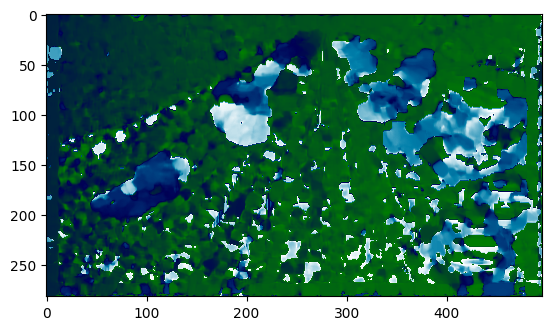

In [44]:
plt.imshow(ang, cmap='ocean') # 'gist_earth_r', 'rainbow_r', 'twilight_r'

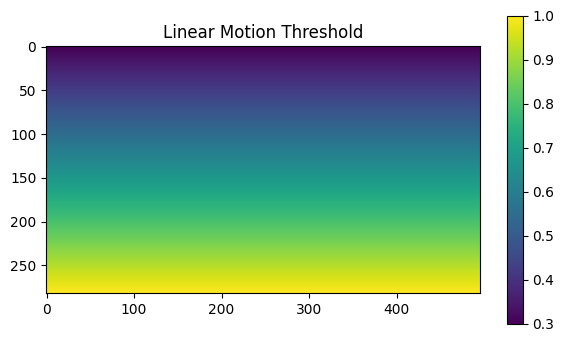

In [45]:
plt.figure(figsize=(7,4))
plt.imshow(motion_thresh)
plt.title("Linear Motion Threshold");
plt.colorbar();

In [46]:
def get_contour_detections_2(mask, ang=ang, angle_thresh=2, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the
        mask. Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            angle_thresh - threshold for flow angle standard deviation
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores
                        [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask,
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE,
                                   cv2.CHAIN_APPROX_TC89_L1)
    temp_mask = np.zeros_like(mask) # used to get flow angle of contours
    angle_thresh = angle_thresh*ang.std()
    detections = []
    for cnt in contours:
        # get area of contour
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h

        # get flow angle inside of contour
        cv2.drawContours(temp_mask, [cnt], 0, (255,), -1)
        flow_angle = ang[np.nonzero(temp_mask)]

        if (area > thresh) and (flow_angle.std() < angle_thresh): # hyperparameter
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

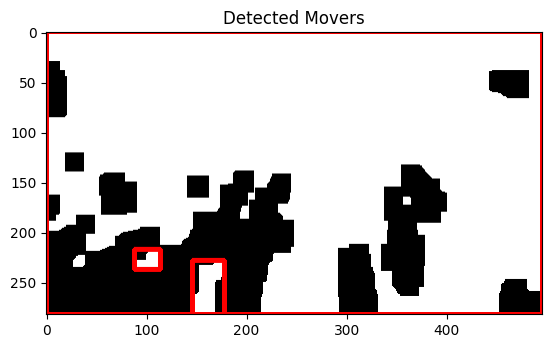

In [47]:
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
detections = get_contour_detections_2(mask, ang, angle_thresh=2, thresh=400)
# detections = get_contour_detections(mask, thresh=400)

# separate bboxes and scores
bboxes = detections[:, :4]
scores = detections[:, -1]

for box in bboxes:
    x1,y1,x2,y2 = box
    cv2.rectangle(mask_rgb, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb)
plt.title("Detected Movers");

In [48]:
nms_bboxes = non_max_suppression(bboxes, scores, threshold=0.1)
len(bboxes), len(nms_bboxes)

(3, 2)

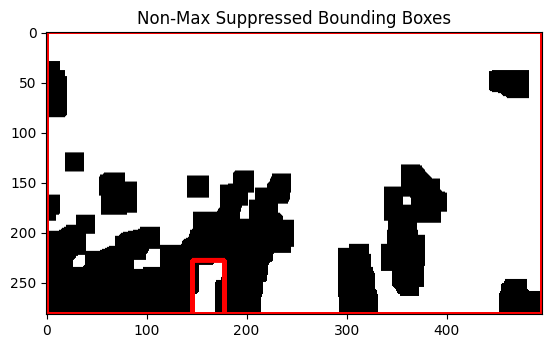

In [49]:
mask_rgb_detections = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
for det in nms_bboxes:
    x1, y1, x2, y2 = det
    cv2.rectangle(mask_rgb_detections, (x1,y1), (x2,y2), (255,0,0), 3)

plt.imshow(mask_rgb_detections)
plt.title("Non-Max Suppressed Bounding Boxes");

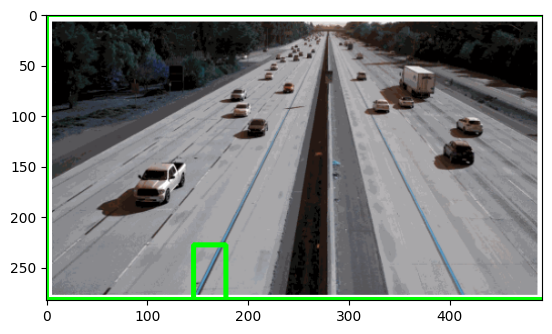

In [50]:
frame2 = img2_rgb.copy()
draw_bboxes(frame2, nms_bboxes)
plt.imshow(frame2);

In [53]:
def get_detections(frame1, frame2, motion_thresh=1, bbox_thresh=400, nms_thresh=0.1, mask_kernel=np.ones((7,7), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            frame1 - Grayscale frame at time t
            frame2 - Grayscale frame at time t + 1
            motion_thresh - Minimum flow threshold for motion
            bbox_thresh - Minimum threshold area for declaring a bounding box
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            mask_kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # get optical flow
    flow = compute_flow(frame1, frame2)

    # separate into magntiude and angle
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # Resize motion_thresh to match the dimensions of mag
    motion_thresh_resized = cv2.resize(motion_thresh.astype(np.float32), (mag.shape[1], mag.shape[0]))

    motion_mask = get_motion_mask(mag, motion_thresh=motion_thresh_resized, kernel=mask_kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(motion_mask, bbox_thresh)

    # separate bboxes and scores
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    # perform Non-Maximal Supression on initial detections
    return non_max_suppression(bboxes, scores, threshold=nms_thresh)

In [54]:
video_frames = []

# get variable motion thresh based on prior knowledge of camera position
motion_thresh = np.c_[np.linspace(0.3, 1, 1080)].repeat(1920, axis=-1)
kernel = np.ones((7,7), dtype=np.uint8)

for idx in range(1, len(image_paths)):
    # read frames
    frame1_bgr = cv2.imread(image_paths[idx - 1])
    frame2_bgr = cv2.imread(image_paths[idx])

    # get detections
    detections = get_detections(frame1_bgr,
                                frame2_bgr,
                                motion_thresh=motion_thresh,
                                bbox_thresh=400,
                                nms_thresh=0.1,
                                mask_kernel=kernel)

    # draw bounding boxes on frame
    draw_bboxes(frame2_bgr, detections)

    # save image for GIF
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(frame2_bgr)
    plt.axis('off')
    fig.savefig(f"temp/frame_{idx}.png")
    plt.close();

    # OPTIONAL append to list for video
    video_frames.append(frame2_bgr)

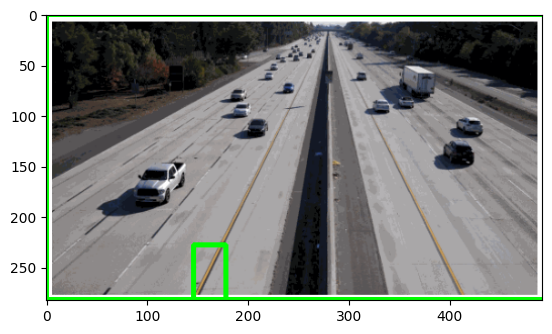

In [55]:
plt.imshow(frame2_bgr)